# Reconocedor de lengua de signos

Vamos a desarrollar una red que reconozca lengua de signos. Para ello, vamos a utilizar un dataset contenido en nuestra cuenta de Google Drive. Antes, debemos montar nuestro sistema de archivos de Google Drive para hacerlo accesible desde este *notebook*. Google nos solicitará permiso, tenemos que copiar y pegar el código que nos suministra.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Ahora ya es accesible

¿Estoy realmente utilizando una GPU? Compruébalo en **Editar / Configuración del cuaderno** o **Entorno de ejecución / Cambiar tipo de entorno de ejecución**

In [8]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Veamos una imagen de ejemplo.

 img  'Inteligencia artificial.ipynb'


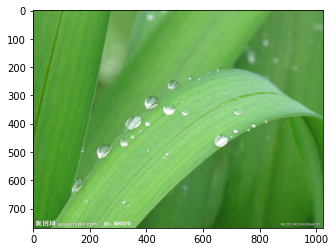

In [9]:
!ls "/content/drive/My Drive/Colab Notebooks/datasets/"

from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open('/content/drive/My Drive/Colab Notebooks/datasets/img/dew/2326.jpg', 'r')
imshow(np.asarray(pil_im))



Data Augmentation

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

import glob

datagen = ImageDataGenerator(
  horizontal_flip=False,
	vertical_flip=False,
	rotation_range=25,
	zoom_range=0.20,
	shear_range=0.20,
	fill_mode="nearest")

for i in range(0, 7, 1):
  clases=("rainbow","dew","sandstorm","rain","lighting","fogsmog","snow")
  for name in glob.glob("/content/drive/My Drive/Colab Notebooks/datasets/img/"+clases[i]+"/*.jpg"):
    #print("/content/drive/My Drive/Colab Notebooks/datasets/img/"+clases[i]+"/*.jpg")
    img = load_img(name)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape) 
    j = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir="/content/drive/My Drive/Colab Notebooks/datasets/img/"+clases[i]+"/data_augmentation/", 
                              save_prefix="image", save_format='jpg'):
      j += 1
      if j >= 2:
        break
print("Finalización del aumento de datos")

Finalización del aumento de datos


## Primer modelo

In [13]:
# DATA SOURCE --------------------------------------------------

image_size = (150, 150)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/img",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/My Drive/Colab Notebooks/datasets/img",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Found 6604 files belonging to 7 classes.
Using 5284 files for training.
Found 6604 files belonging to 7 classes.
Using 1320 files for validation.


In [22]:
# MODEL --------------------------------------------------

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from tensorflow.keras.callbacks import EarlyStopping

model = keras.Sequential()
model.add(Rescaling(scale=(1./127.5),
                    offset=-1, 
                    input_shape=(150, 150, 3)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(256, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [23]:
# TRAINING --------------------------------------------------

epochs = 200

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)

h = model.fit(
        train_ds,
        epochs=epochs, 
        validation_data=val_ds,
        callbacks = [es]
)

Epoch 1/200
166/166 [==============================] - 20s 111ms/step - loss: 0.9245 - accuracy: 0.6853 - val_loss: 0.6342 - val_accuracy: 0.7697
Epoch 2/200
166/166 [==============================] - 19s 110ms/step - loss: 0.6137 - accuracy: 0.7950 - val_loss: 0.5038 - val_accuracy: 0.8159
Epoch 3/200
166/166 [==============================] - 19s 110ms/step - loss: 0.4805 - accuracy: 0.8391 - val_loss: 0.4662 - val_accuracy: 0.8311
Epoch 4/200
166/166 [==============================] - 19s 110ms/step - loss: 0.4397 - accuracy: 0.8583 - val_loss: 0.4344 - val_accuracy: 0.8500
Epoch 5/200
166/166 [==============================] - 21s 122ms/step - loss: 0.3530 - accuracy: 0.8846 - val_loss: 0.3477 - val_accuracy: 0.8856
Epoch 6/200
166/166 [==============================] - 19s 109ms/step - loss: 0.3361 - accuracy: 0.8899 - val_loss: 0.3459 - val_accuracy: 0.8924
Epoch 7/200
166/166 [==============================] - 19s 110ms/step - loss: 0.3058 - accuracy: 0.9054 - val_loss: 0.3007 -

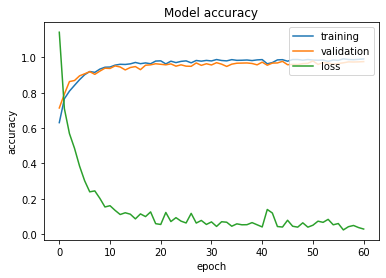

In [16]:
import matplotlib.pyplot as plt

plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.plot(h.history['loss'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation','loss'], loc='upper right')
plt.show()

## Evaluación de los resultados

1/1 [==============================] - 0s 78ms/step
              precision    recall  f1-score   support

           0     1.0000    0.9721    0.9858       215
           1     0.9689    0.9639    0.9664       194
           2     0.8500    1.0000    0.9189        17
           3     0.9595    0.9907    0.9748       215
           4     0.9898    0.9898    0.9898       294
           5     0.9815    0.9725    0.9770       218
           6     0.9880    0.9820    0.9850       167

    accuracy                         0.9795      1320
   macro avg     0.9625    0.9816    0.9711      1320
weighted avg     0.9800    0.9795    0.9796      1320



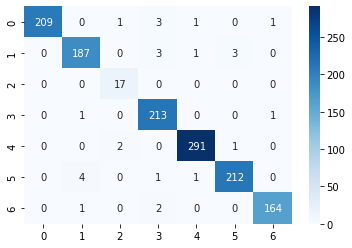

In [17]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))

In [20]:
img = keras.preprocessing.image.load_img(
   '/content/drive/My Drive/Colab Notebooks/datasets/img/dew/2284.jpg', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(np.argmax(predictions[0]))

1/1 [==============================] - 0s 19ms/step
0


32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
32
8
1/1 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

           0     1.0000    0.9721    0.9858       215
           1     0.9689    0.9639    0.9664       194
           2     0.8500    1.0000    0.9189        17
           3     0.9595    0.9907    0.9748       215
           4     0.9898    0.9898    0.9898       294
           5     0.9815    0.9725    0.9770       218
           6     0.9880    0.9820    0.9850       167

    accuracy                         0.9795      1320
   macro avg     0.9625    0.9816    0.9711      1320
weighted avg     0.9800    0.9795    0.9796      1320



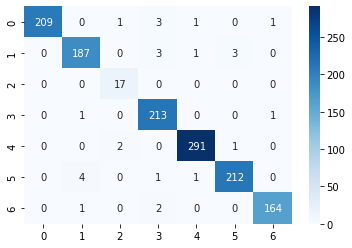

In [21]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

for x, y in val_ds:
  print(len(y))

results = np.concatenate([(y, model.predict(x=x)) for x, y in val_ds], axis=1)

predictions = np.argmax(results[0], axis=1)
labels = np.argmax(results[1], axis=1)

cf_matrix = confusion_matrix(labels, predictions)

sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues")

print(classification_report(labels, predictions, digits = 4))